## 0. Install dependencies    

In [ ]:
!pip install -r requirements.txt

In [127]:
!pip install cryptography==36.0.2

                                              0.0/2.2 MB ? eta -:--:--
                                              0.0/2.2 MB 1.4 MB/s eta 0:00:02
                                              0.0/2.2 MB 1.4 MB/s eta 0:00:02
     --                                       0.1/2.2 MB 939.4 kB/s eta 0:00:03
     --                                       0.1/2.2 MB 939.4 kB/s eta 0:00:03
     ----                                     0.2/2.2 MB 1.0 MB/s eta 0:00:02
     ----                                     0.2/2.2 MB 1.0 MB/s eta 0:00:02
     -------                                  0.4/2.2 MB 1.3 MB/s eta 0:00:02
     ---------                                0.5/2.2 MB 1.4 MB/s eta 0:00:02
     ------------                             0.7/2.2 MB 1.6 MB/s eta 0:00:01
     ------------                             0.7/2.2 MB 1.6 MB/s eta 0:00:01
     ------------                             0.7/2.2 MB 1.6 MB/s eta 0:00:01
     ------------                             0.7/2.2 MB 1.6 MB/s e

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pyopenssl 23.0.0 requires cryptography<40,>=38.0.0, but you have cryptography 36.0.2 which is incompatible.


In [8]:
!pip install opendatasets
!pip install pandas

In [145]:
import opendatasets as od
import numpy as np
import pandas
import matplotlib.pylab as plt
import pandas as pd
from glob import glob
import os
import xml.etree.ElementTree as ET
from collections import Counter

#implementing HOG
from skimage.feature import hog
from skimage import exposure
import matplotlib.pyplot as plt
import cv2

#implementing SIFT 
import cv2
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt

##  1. Download data

Detail about the dataset and how i created script for downloading the dataset through notebook
https://www.geeksforgeeks.org/how-to-download-kaggle-datasets-into-jupyter-notebook/

In [6]:
od.download("https://www.kaggle.com/datasets/khlaifiabilel/military-aircraft-recognition-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: tymofiij
Your Kaggle Key: ········


100%|█████████████████████████████████████████████████████████████████████████████| 1.13G/1.13G [16:51<00:00, 1.19MB/s]


## 2. Analyze data

Analyzing dataset structure, Getting amount of files <br>
// write here conclusions(Data Augmentation Needs, Determine the number of color channels in the images )<br>
// verify the format of image data (JPG, PNG, etc.).<br>
// Consider how to improve evaluation metrics (accuracy, precision, recall, F1-score).


analyzing amount of data, verifying format(whether all pictures are .jpg)
// add a little bit of Data Cleaning/Data Quality tests

In [230]:
def extract_numeric_part(filename):
    return int(''.join(filter(str.isdigit, filename)))


annotations_horizontal_boxes = os.listdir('military-aircraft-recognition-dataset/Annotations/Horizontal Bounding Boxes/')
annotations_oriented_boxes = os.listdir("military-aircraft-recognition-dataset/Annotations/Oriented Bounding Boxes/")
images = os.listdir("military-aircraft-recognition-dataset/JPEGImages/")
print(len(annotations_horizontal_boxes))
print(len(annotations_horizontal))
print(len(annotations_oriented_boxes))
                    
annotations_horizontal_boxes = sorted(glob("military-aircraft-recognition-dataset/Annotations/Horizontal Bounding Boxes/*.xml"), key=extract_numeric_part)
annotations_oriented_boxes = sorted(glob("military-aircraft-recognition-dataset/Annotations/Oriented Bounding Boxes/*.xml"), key=extract_numeric_part)
images = glob("military-aircraft-recognition-dataset\JPEGImages\*.jpg")

# Sort the list of file paths using the custom sorting key
annotations_horizontal_boxes = sorted(annotations_horizontal_boxes, key=extract_numeric_part)
print(annotations_horizontal_boxes[0])

print(len(images))
print(len(annotations_horizontal))
print(len(annotations_oriented_boxes))

3842
3842
3842
military-aircraft-recognition-dataset/Annotations/Horizontal Bounding Boxes\1.xml
3842
3842
3842


Show distribution of picture size + analyze dimensions

In [119]:
sizes = []
for image in images:
    image = plt.imread(image)
    sizes.append(image.shape)
print(sizes)

[(831, 859, 3), (834, 752, 3), (755, 755, 3), (800, 800, 3), (800, 800, 3), (800, 800, 3), (800, 800, 3), (800, 800, 3), (800, 800, 3), (800, 800, 3), (800, 800, 3), (800, 800, 3), (800, 800, 3), (686, 686, 3), (800, 800, 3), (800, 800, 3), (800, 800, 3), (800, 800, 3), (800, 800, 3), (800, 800, 3), (800, 800, 3), (800, 800, 3), (800, 800, 3), (800, 800, 3), (741, 779, 3), (800, 800, 3), (800, 800, 3), (800, 800, 3), (800, 800, 3), (800, 800, 3), (800, 800, 3), (800, 800, 3), (800, 800, 3), (800, 800, 3), (800, 800, 3), (751, 751, 3), (800, 800, 3), (800, 800, 3), (800, 800, 3), (800, 800, 3), (800, 800, 3), (800, 800, 3), (800, 800, 3), (800, 800, 3), (800, 800, 3), (800, 800, 3), (734, 734, 3), (800, 800, 3), (800, 800, 3), (800, 800, 3), (800, 800, 3), (800, 800, 3), (800, 800, 3), (800, 800, 3), (800, 800, 3), (800, 800, 3), (800, 800, 3), (745, 745, 3), (800, 800, 3), (800, 800, 3), (800, 800, 3), (800, 800, 3), (800, 800, 3), (800, 800, 3), (800, 800, 3), (800, 800, 3), (800, 800

In [123]:
widths = [shape[0] for shape in sizes]
heights = [shape[1] for shape in sizes]
dimensions = [shape[2] for shape in sizes]

width_counts = dict(zip(*np.unique(widths, return_counts=True)))
height_counts = dict(zip(*np.unique(heights, return_counts=True)))
dimension_counts = dict(zip(*np.unique(dimensions, return_counts=True)))

In [124]:
width_median = np.median(widths)
height_median = np.median(heights)
dimension_median = np.median(dimensions)

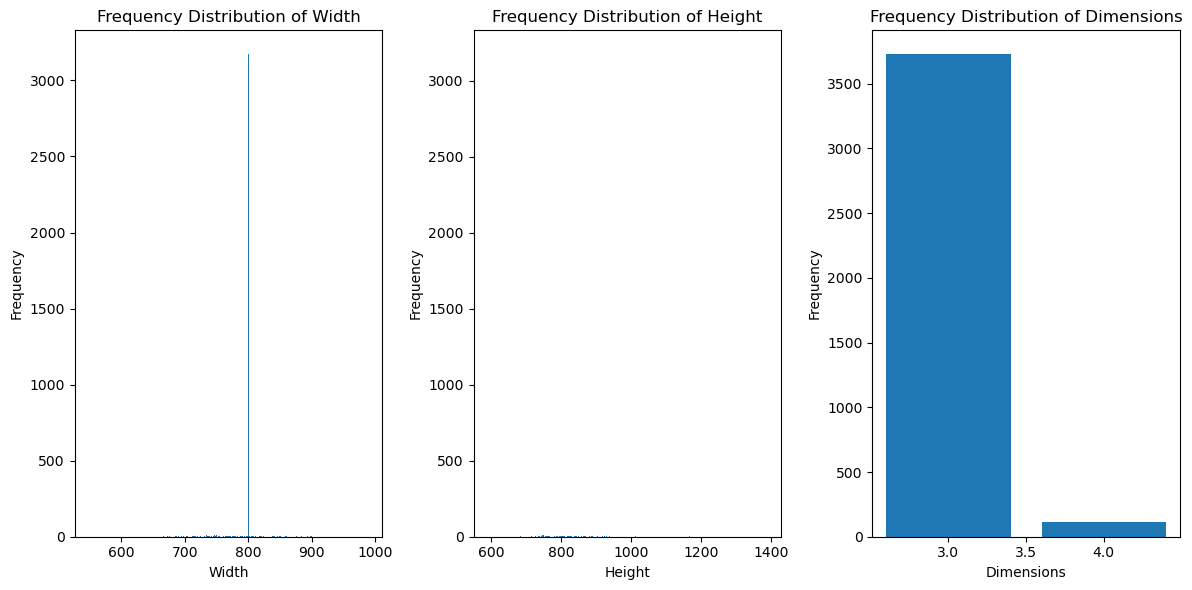

Median Width: 800.0
Median Height: 800.0
Median Dimensions: 3.0


In [125]:
plt.figure(figsize=(12, 6))
plt.subplot(131)
plt.bar(width_counts.keys(), width_counts.values())
plt.xlabel('Width')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Width')

plt.subplot(132)
plt.bar(height_counts.keys(), height_counts.values())
plt.xlabel('Height')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Height')

plt.subplot(133)
plt.bar(dimension_counts.keys(), dimension_counts.values())
plt.xlabel('Dimensions')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Dimensions')

plt.tight_layout()
plt.show()

print(f"Median Width: {width_median}")
print(f"Median Height: {height_median}")
print(f"Median Dimensions: {dimension_median}")

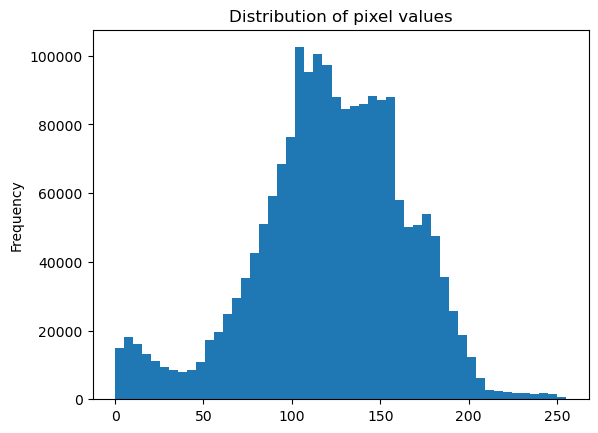

In [120]:
img = plt.imread(images[111])
pd.Series(img.flatten()).plot(kind="hist",bins=50, title = "Distribution of pixel values")
plt.show()

In [113]:
def get_class_frequencies(file_path, annotations_horizontal_boxes):
    names = []
    with open(file_path, 'r') as file:
        numbers = [int(line.strip()) for line in file]
        for i in numbers:
            annotation = annotations_horizontal_boxes[i-1]
            tree = ET.parse(annotation)
            root = tree.getroot()
            for object_element in root.findall('.//object'):
                name_element = object_element.find('name')
                if name_element is not None:
                    names.append(name_element.text)
    return names

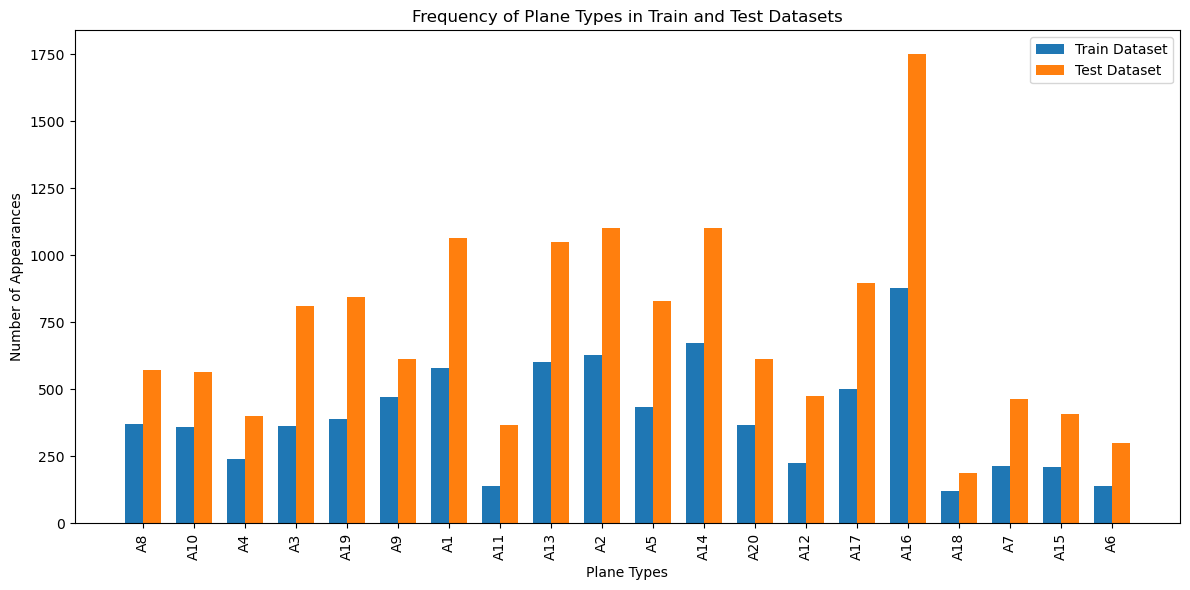

In [116]:
train_txt_path = 'military-aircraft-recognition-dataset/ImageSets/Main/train.txt'
test_txt_path = 'military-aircraft-recognition-dataset/ImageSets/Main/test.txt'

train_names = get_class_frequencies(train_txt_path, annotations_horizontal_boxes)
test_names = get_class_frequencies(test_txt_path, annotations_horizontal_boxes)

train_counter = Counter(train_names)
test_counter = Counter(test_names)

types = list(train_counter.keys())
train_counts = [train_counter[type] for type in types]
test_counts = [test_counter[type] for type in types]

plt.figure(figsize=(12, 6))
width = 0.35
x = range(len(types))

plt.bar(x, train_counts, width, label='Train Dataset')
plt.bar([i + width for i in x], test_counts, width, label='Test Dataset')

plt.xlabel('Plane Types')
plt.ylabel('Number of Appearances')
plt.title('Frequency of Plane Types in Train and Test Datasets')
plt.xticks([i + width/2 for i in x], types, rotation=90)  # Rotate x-axis labels for readability
plt.legend()
plt.tight_layout()

plt.show()


Show here example of every plane type 

(800, 800, 3)


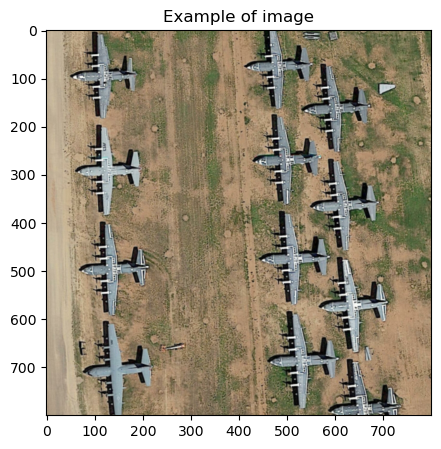

In [102]:
fig, ax = plt.subplots(figsize = (5,5))
ax.imshow(img)
plt.title('Example of image')
print(img.shape)
plt.show()

Ideas: implement feature detection using CNN or Scale-Invariant Feature Transform or HOG

Let's try HOG first as it seems to be the most easy thing to show

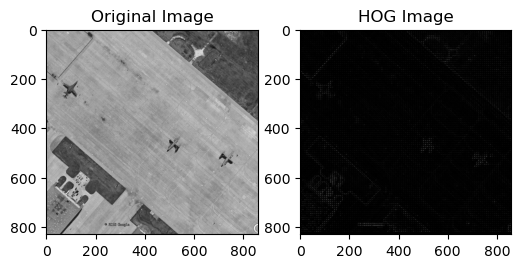

In [133]:
image = cv2.imread(images[0], cv2.IMREAD_GRAYSCALE)

features, hog_image = hog(image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)

plt.figure(figsize=(6, 6))
plt.subplot(121)
plt.imshow(image, cmap=plt.cm.gray)
plt.title('Original Image')

plt.subplot(122)
plt.imshow(hog_image, cmap=plt.cm.gray)
plt.title('HOG Image')

plt.show()

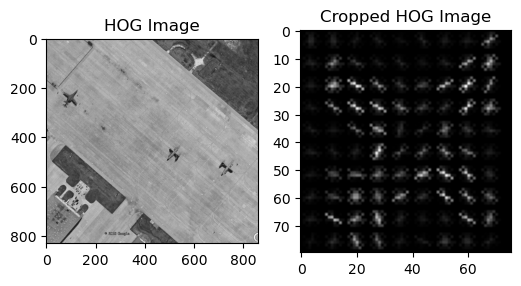

In [144]:
image = cv2.imread(images[0], cv2.IMREAD_GRAYSCALE)

xml_file = annotations_horizontal_boxes[0]
tree = ET.parse(xml_file)
root = tree.getroot()
cropped_images = []
for object_element in root.findall('.//object'):
    name_element = object_element.find('name')
    robndbox_element = object_element.find('bndbox')

    if name_element is not None and robndbox_element is not None:
        label = name_element.text

        x_left_top = float(robndbox_element.find('xmin').text)
        y_left_top = float(robndbox_element.find('ymin').text)
        x_right_top = float(robndbox_element.find('xmax').text)
        y_right_top = float(robndbox_element.find('ymax').text)

        cropped_region = image[int(y_left_top):int(y_right_top), int(x_left_top):int(x_right_top)]

        cropped_images.append(cropped_region)
plt.figure(figsize=(6, 6))
plt.subplot(121)
plt.imshow(image, cmap=plt.cm.gray)
plt.title('HOG Image')

for i, cropped_image in enumerate(cropped_images):
    features, hog_image = hog(cropped_image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
    plt.subplot(122)
    plt.imshow(hog_image, cmap=plt.cm.gray)
    plt.title('Cropped HOG Image')



['military-aircraft-recognition-dataset\\JPEGImages\\1.jpg', 'military-aircraft-recognition-dataset\\JPEGImages\\10.jpg', 'military-aircraft-recognition-dataset\\JPEGImages\\100.jpg', 'military-aircraft-recognition-dataset\\JPEGImages\\1000.jpg', 'military-aircraft-recognition-dataset\\JPEGImages\\1001.jpg', 'military-aircraft-recognition-dataset\\JPEGImages\\1002.jpg', 'military-aircraft-recognition-dataset\\JPEGImages\\1003.jpg', 'military-aircraft-recognition-dataset\\JPEGImages\\1004.jpg', 'military-aircraft-recognition-dataset\\JPEGImages\\1005.jpg', 'military-aircraft-recognition-dataset\\JPEGImages\\1006.jpg', 'military-aircraft-recognition-dataset\\JPEGImages\\1007.jpg', 'military-aircraft-recognition-dataset\\JPEGImages\\1008.jpg', 'military-aircraft-recognition-dataset\\JPEGImages\\1009.jpg', 'military-aircraft-recognition-dataset\\JPEGImages\\101.jpg', 'military-aircraft-recognition-dataset\\JPEGImages\\1010.jpg', 'military-aircraft-recognition-dataset\\JPEGImages\\1011.jpg'

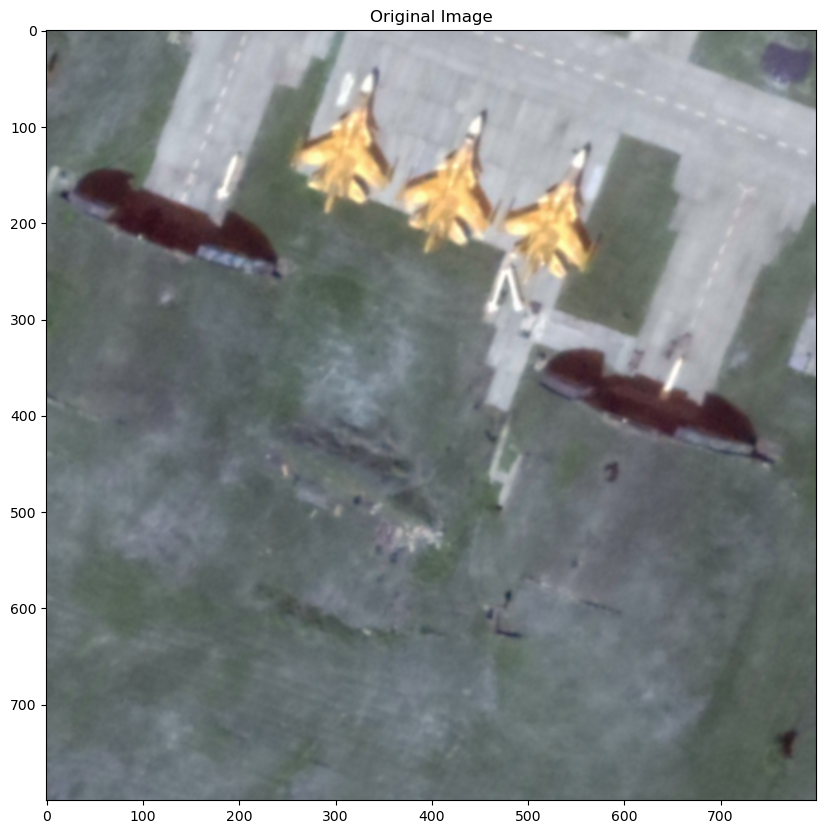

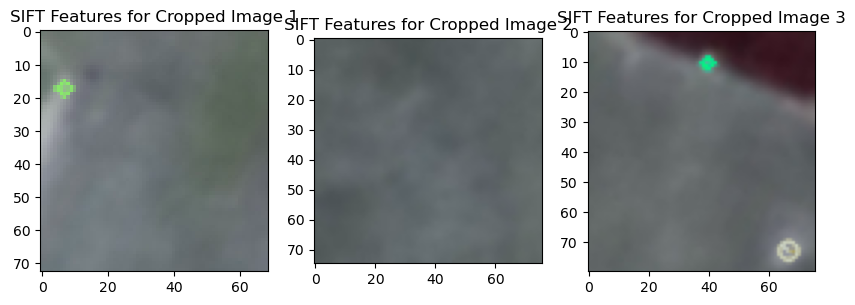

In [195]:
print(images)
image = cv2.imread(images[21])


sift_features = []

ml_file = annotations_horizontal_boxes[21]
tree = ET.parse(xml_file)
root = tree.getroot()
cropped_images = []
for object_element in root.findall('.//object'):
    name_element = object_element.find('name')
    bndbox_element = object_element.find('bndbox')

    if name_element is not None and bndbox_element is not None:
        label = name_element.text

        x_left_top = int(bndbox_element.find('xmin').text)
        y_left_top = int(bndbox_element.find('ymin').text)
        x_right_bottom = int(bndbox_element.find('xmax').text)
        y_right_bottom = int(bndbox_element.find('ymax').text)

        cropped_region = image[y_left_top:y_right_bottom, x_left_top:x_right_bottom]

        sift = cv2.SIFT_create()

        key_points, descriptors = sift.detectAndCompute(cropped_region, None)

        sift_features.append((key_points, descriptors))   
        
        cropped_images.append((label,cropped_region))
        
plt.figure(figsize=(10, 10))
plt.imshow(image, cmap=plt.cm.gray)
plt.title('Original Image')

# Display SIFT features for each cropped region
for i, (key_points, descriptors) in enumerate(sift_features):
    if i % 3 == 0:
        # Create a new row of images every 3 images
        plt.figure(figsize=(10, 6))

    plt.subplot(1, 3, i % 3 + 1)
    plt.imshow(cropped_images[i][1], cmap=plt.cm.gray)
    plt.title(f'SIFT Features for Cropped Image {i + 1}')
    img_with_keypoints = cv2.drawKeypoints(cropped_images[i][1], key_points, outImage=cropped_images[i][1], flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.imshow(img_with_keypoints, cmap=plt.cm.gray)

    if (i + 1) % 3 == 0 or (i + 1) == len(sift_features):
        # Show the row of images when 3 images have been added or it's the last iteration
        plt.show()

# Show the final result
plt.show()

